In [1]:
import sys
workPath = '/home/jovyan/workspace'
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
import planetengine
outputPath = planetengine.paths.make_testdir()

In [3]:
system = planetengine.tests.testsystems.get_system()

Fitted 1 variables to the figure.


In [21]:
import planetengine
from planetengine import checkpoint
import os

class Observer(planetengine._built.Built):

    name = 'anonObs'

    def __init__(
            self,
            args,
            kwargs,
            inputs,
            script,
            _attach,
            _prompt,
            ):

        self._prompt = _prompt
        self._attach = _attach

        self.path = ''

        super().__init__(
            args = args,
            kwargs = kwargs,
            inputs = inputs,
            script = script
            )

    def attach(self, system):

        assert hasattr(system, 'initials'), \
            "System must have initials set."

        builts = {
            'observer': self,
            'observed': {
                'system': system,
                'initials': system.initials
                }
            }

        saveVars, saveFigs, saveCollectors = \
            self._attach(system)

        for sub in self.subs:
            sub_saveVars, sub_saveFigs, sub_saveCollectors = \
                sub._attach(system)
            saveVars.extend(sub_saveVars)
            saveFigs.append(sub_saveFigs)
            saveCollectors.append(sub_saveCollectors)

        checkpointer = checkpoint.Checkpointer(
            step = system.step,
            modeltime = system.modeltime,
            saveVars = saveVars,
            figs = saveFigs,
            dataCollectors = saveCollectors,
            builts = builts
            )

        self.system = system
        self.initials = system.initials
        self.builts = builts
        self.saveVars = saveVars
        self.figs = saveFigs
        self.collectors = saveCollectors
        self.checkpointer = checkpointer
        self.step = system.step
        self.modeltime = system.modeltime

    def attach_frame(self, frame):
        self.attach(frame.system)
        frame.observers.add(self)
        self.path = os.path.join(frame.path, self.name)

    def prompt(self, status = None):
        self._prompt()
        if status == 'checkpointing':
            self.checkpoint()

    def checkpoint(self, path = None, clear = True):
        if path is None:
            path = self.path
        self.checkpointer.checkpoint(path)
        if path == self.path:
            for collector in self.saveCollectors:
                collector.clear()

In [26]:
import planetengine
from planetengine import functions as pfn
from planetengine.visualisation import QuickFig
from planetengine import analysis

def build(*args, name = None, **kwargs):
    built = Standard(*args, **kwargs)
    if type(name) == str:
        built.name = name
    return built

class Standard(Observer):

    script = 'test.py' # __file__
    name = 'standard'

    def __init__(
            self,
            *args,
            **kwargs
            ):

        inputs = locals().copy()

        super().__init__(
            args,
            kwargs,
            inputs,
            self.script,
            self._attach,
            self._prompt
            )

    def _attach(self, system):

        varDict = {}

        keys = {'temperature', 'velocity', 'stress'}
        obsVars = {key: system.obsVars[key] for key in keys}
        obsVars = pfn.convert(obsVars)


        temperature = obsVars['temperature']
        velocity = obsVars['velocity']
        stress = obsVars['stress']

        saveVars = {'velocity': velocity, 'stress': stress}

        stressMag = pfn.Component.mag(stress)
        avStress = pfn.Integral(stressMag)
        avTemp = pfn.Integral(temperature)
        tempGrad = pfn.Gradient.rad(temperature)
        Nu = pfn.Integral.outer(tempGrad) / pfn.Integral.inner(temperature) * -1.
        velMag = pfn.Component.mag(velocity)
        VRMS = pfn.Integral(velMag)
        horizVel = pfn.Component.ang(velocity)
        surfVRMS = pfn.Integral(horizVel)

        statsDict = {
            'avStress': avStress,
            'avTemp': avTemp,
            'Nu': Nu,
            'VRMS': VRMS,
            'surfVRMS': surfVRMS
            }

        formatDict = {
            'Nu': "{:.2f}",
            'avTemp': "{:.2f}",
            'VRMS': "{:.2f}",
            'surfVRMS': "{:.2f}",
            'avStress': "{:.2f}"
            }

        mainAnalyser = analysis.Analyser(
            'standard',
            statsDict,
            formatDict,
            system.step,
            system.modeltime
            )
        mainCollector = analysis.DataCollector([mainAnalyser,])

        saveCollectors = [mainCollector,]

        mainFig = QuickFig(
            temperature,
            velocity,
            stressMag,
            style = 'smallblack'
            )

        saveFigs = [mainFig]

        self.mainAnalyser = mainAnalyser
        self.mainCollector = mainCollector
        self.mainFig = mainFig
        
        return saveVars, saveFigs, saveCollectors

    def _prompt(self):
        if self.step() % 10 == 0:
            planetengine.message("Analysing...")
            self.mainCollector.collect()
            planetengine.message("Analysed.")

    def report(self):
        self.mainAnalyser.report()
        self.mainFig.show()

In [27]:
myObs = Standard()

In [28]:
myObs.attach(system)

Fitted 2 variables to the figure.


In [29]:
myObs.prompt()

Analysing...
Analysed.


In [32]:
from planetengine.paths import make_testdir

In [33]:
mydir = make_testdir()

In [34]:
myObs.checkpoint(mydir)

Attempting to checkpoint...
Checking for pre-existing frame on disk...
No pre-existing directory for this model found. Making a new one...
Checkpointing...
Making checkpoint directory.
Saving figures...
Figures saved.
Saving vars of state...
Saving substrate to disk: mesh
Saving var to disk: stress
Saving var to disk: velocity
Saved.
Saving snapshot...
Snapshot saved.
Saving datasets...
Datasets saved.
Checkpointed!


avStress
97500.75
avTemp
0.45
modeltime
3.5E-04
Nu
1.01
step
110
surfVRMS
-8.67
VRMS
192.48
Variable_varName=temperature{}
Variable_varName=velocity{}



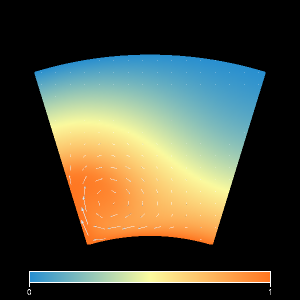

In [17]:
myObs.report()

In [18]:
system.go(10)

avStress
97500.75
avTemp
0.45
modeltime
3.7E-04
Nu
1.01
step
120
surfVRMS
-8.47
VRMS
189.69
Variable_varName=temperature{}
Variable_varName=velocity{}



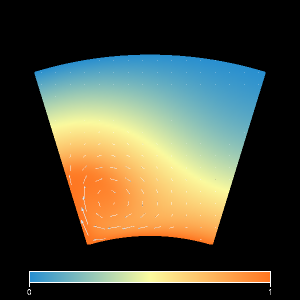

In [19]:
myObs.report()

In [36]:
planetengine._built.load_builtsDir(mydir)

Hello world!


AttributeError: module 'observer_0.py' has no attribute 'build'